In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.patches as mpatches
import seaborn as sns
import geopandas as gpd
import contextily as cx
from PIL import Image

from PlotsForPaper_Functions import *

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
import sys
sys.path.append("../ProcessModelResults/")
from my_functions import *

In [3]:
methods_dict = {'Idealised': ['6h_sp_fl_0.1', '6h_sp_fl_0.2', '6h_sp_fl_0.3', '6h_sp_fl_0.4','6h_sp_c_0.5',
          '6h_sp_bl_0.6','6h_sp_bl_0.7','6h_sp_bl_0.8','6h_sp_bl_0.9'],
                'Observed':['6h_feh_singlepeak', '6h_c1','6h_c2','6h_c3','6h_c4', '6h_c5', '6h_c6','6h_c7',
             '6h_c8','6h_c9','6h_c10', '6h_c11', '6h_c12','6h_c13','6h_c14','6h_c15'], 
               'SinglePeak_Scaled':['6h_sp_+0%','6h_sp_+5%','6h_sp_+10%','6h_sp_+15%','6h_sp_+20%']}

## Plot catchments

In [4]:
methods_key ='Idealised'
catchment_name = 'WykeBeck'
model_directory = '../../../FloodModelling/{}Models/Model_{}Profiles_export/'.format(catchment_name, methods_key)

In [5]:
sys.path.append("../")
from my_functions import *

if catchment_name == 'LinDyke':
    catchment_name_str = "Resampled.Terrain" 
    catchment_shpfilename = 'CatchmentLinDyke_exported'
    minx, miny, maxx, maxy  = 437000,  426500,  445500, 434300
    crop_or_not = True
    catchment_gdf = gpd.read_file(model_directory + 'CatchmentLinDyke_exported.shp')
    
elif catchment_name == 'WykeBeck':
    catchment_name_str = "Terrain.wykeDEM" 
    catchment_shpfilename = 'WykeBeckCatchment'
    minx, miny, maxx, maxy = 430004,  429978, 438660, 440996
    catchment_gdf = gpd.read_file(model_directory + 'WykeBeckCatchment.shp')
    crop_or_not = False
# Create a bounding box (this is used in preparing the rasters)
bbox = box(minx, miny, maxx, maxy)

In [6]:
landcover_directory = '../../../FloodModelling/{}Models/LandCoverData/'.format(catchment_name)
# Water landcover classification - 10 is water, 11 is eveyrthing else
with rasterio.open(landcover_directory + 'LandCover_notwater_classification.tif', 'r') as ds:
    landcover_notwater = ds.read()[0]
    out_meta = ds.meta

In [8]:
# fig,ax=plt.subplots()
# geo = gpd.GeoDataFrame({'geometry': bbox}, index=[0], crs=CRS('EPSG:27700'))     
# # Re-project into the same coordinate system as the raster data
# geo = geo.to_crs(crs=CRS('EPSG:27700'))#data.crs.data
# geo.plot(ax=ax,color='White', edgecolor='black')
# catchment_gdf.plot(ax=ax, facecolor=None)

In [7]:
# # Loop through methods
# for method in methods_dict[methods_key]:
#     print(method)
    
#     # Create lists to store the values for each timeslice for this method
#     n_flooded_cells_2hrs = []
#     n_flooded_cells_2hrs_over10cm = []
#     n_flooded_cells_2hrs_notwater = []
#     dates = []
    
#     # List of all the Hours and Minutes that we need
#     Hs=range(0,12,2)
#     M = '00'
#     Hs_dict = {1:range(12,24,2), 2: range(0,24,2), 3: range(0,24,2), 4: range(0,12,2)}
    
#     # Loop through each timeslice
#     for D in range(1,2,1):
#         Hs = Hs_dict[D]
#         for H in Hs:
#             H = str(H).zfill(2)
                
#             if methods_key == 'Observed' and method == '6h_feh_singlepeak':
#                 # fp = '../../../FloodModelling/{}Models/Model_FEHProfiles_export/6h_feh_singlepeak/Depth (01AUG2022 {} 00 00).Resampled.Terrain.tif'.format(catchment_name, D, H)
#                 fp = '../../../FloodModelling/{}Models/Model_FEHProfiles_export/6h_feh_singlepeak/Depth (0{}AUG2022 {} {} 00).Terrain.wykeDEM.tif'.format(catchment_name, D, H, M)
#                 if H == "12" and D ==1 :
#                     fp = '../../../FloodModelling/{}Models/Model_FEHProfiles_export/6h_feh_singlepeak/Depth (0{}AUG2022 {} 01 00).Terrain.wykeDEM.tif'.format(catchment_name, D, H)
                    
#             else:
#                 #fp = model_directory + '{}/Depth (01AUG2022 {} 00 00).Resampled.Terrain.tif'.format(method, D, H)
#                 fp = model_directory + '{}/Depth (0{}AUG2022 {} {} 00).Terrain.wykeDEM.tif'.format(method, D, H, M)
#                 if H == "12" and D ==1 :
#                     fp = model_directory + '{}/Depth (0{}AUG2022 {} 01 00).Terrain.wykeDEM.tif'.format(method, D, H)
                    
#             # To not crash the script if this timeslice's data isnt downloaded
#             try:
#                 f = open(fp)

#             except:
#                 print(fp)

### First 8 hours: 30 mins

In [39]:
# Create dictionaries to store results for each method
n_flooded_cells_dict = {}
n_flooded_cells_dict_over10cm = {}
n_flooded_cells_dict_notwater = {}

# Loop through methods
for method in methods_dict[methods_key]:
    print(method)
    
    # Create lists to store the values for each timeslice for this method
    n_flooded_cells = []
    n_flooded_cells_over10cm = []
    n_flooded_cells_notwater = []
    dates = []
    
    # List of all the Hours and Minutes that we need
    Hs=range(12,21,1)
    Ms= range(0,60,30)
    D = 1 
    # Loop through each timeslice
    for H in Hs:
        for M in Ms:
            M = str(M).zfill(2)
            if methods_key == 'Observed' and method == '6h_feh_singlepeak':
                # fp = '../../../FloodModelling/{}Models/Model_FEHProfiles_export/6h_feh_singlepeak/Depth (01AUG2022 {} 00 00).Resampled.Terrain.tif'.format(catchment_name, D, H)
                fp = '../../../FloodModelling/{}Models/Model_FEHProfiles_export/6h_feh_singlepeak/Depth (0{}AUG2022 {} {} 00).Terrain.wykeDEM.tif'.format(catchment_name, D, H, M)
            else:
                #fp = model_directory + '{}/Depth (01AUG2022 {} 00 00).Resampled.Terrain.tif'.format(method, D, H)
                fp = model_directory + '{}/Depth (0{}AUG2022 {} {} 00).Terrain.wykeDEM.tif'.format(method, D, H, M)
            
            #try:
            #    f = open(fp)
            
            # To not crash the script if this timeslice's data isnt downloaded
            try:
                ###################################
                # Get the number of cells with flooding >0.1m
                ###################################
                # Get the data for this timeslice
                depth_timeslice, out_meta = open_and_clip_to_catchment(fp, catchment_gdf, crop_or_not = crop_or_not)
                number_flooded_cells = depth_timeslice[depth_timeslice>0].size
                n_flooded_cells.append(number_flooded_cells)

                # Remove values <0.1m
                depth_timeslice = remove_little_values_fxn(depth_timeslice, fp, catchment_gdf, crop_or_not = crop_or_not)   
                # Count the number of flooded cells (shouldnt need the filter by 0.1 as already done)
                number_flooded_cells_over10cm = depth_timeslice[depth_timeslice>0.1].size
                # Add values to list
                n_flooded_cells_over10cm.append(number_flooded_cells_over10cm)

                ###################################
                # Get the number of cells with flooding >0.1m which aren't areas or permanent water
                ###################################
                depth_timeslice_and_landcover = pd.DataFrame({'landcovercategory':  landcover_notwater.flatten(),
                                                              'counts': depth_timeslice.flatten()})
                # Keep just the rows in the relevant landcoverclass
                df = depth_timeslice_and_landcover[depth_timeslice_and_landcover['landcovercategory']==10].copy()  
                # remove the NA values (i.e. where there is no flooding)
                df=df[df.counts.notnull()]
                # Count number of flooded cells which aren't water
                number_flooded_cells_not_water = len(df)
                # Add values to list
                n_flooded_cells_notwater.append(number_flooded_cells_not_water)

            except:
                print(fp)
    
    # Add to dict
    n_flooded_cells_dict[method] = n_flooded_cells
    n_flooded_cells_dict_over10cm[method] = n_flooded_cells_over10cm
    n_flooded_cells_dict_notwater[method] = n_flooded_cells_notwater
    

6h_sp_fl_0.1
../../../FloodModelling/WykeBeckModels/Model_IdealisedProfiles_export/6h_sp_fl_0.1/Depth (01AUG2022 12 00 00).Terrain.wykeDEM.tif


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


../../../FloodModelling/WykeBeckModels/Model_IdealisedProfiles_export/6h_sp_fl_0.1/Depth (01AUG2022 18 30 00).Terrain.wykeDEM.tif
6h_sp_fl_0.2
../../../FloodModelling/WykeBeckModels/Model_IdealisedProfiles_export/6h_sp_fl_0.2/Depth (01AUG2022 12 00 00).Terrain.wykeDEM.tif


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


../../../FloodModelling/WykeBeckModels/Model_IdealisedProfiles_export/6h_sp_fl_0.2/Depth (01AUG2022 18 00 00).Terrain.wykeDEM.tif
6h_sp_fl_0.3
../../../FloodModelling/WykeBeckModels/Model_IdealisedProfiles_export/6h_sp_fl_0.3/Depth (01AUG2022 12 00 00).Terrain.wykeDEM.tif
6h_sp_fl_0.4
../../../FloodModelling/WykeBeckModels/Model_IdealisedProfiles_export/6h_sp_fl_0.4/Depth (01AUG2022 12 00 00).Terrain.wykeDEM.tif
6h_sp_c_0.5
../../../FloodModelling/WykeBeckModels/Model_IdealisedProfiles_export/6h_sp_c_0.5/Depth (01AUG2022 12 00 00).Terrain.wykeDEM.tif


/nfs/a321/gy17m2a/anaconda_install/anaconda3/envs/pygeospatial/lib/python3.9/site-packages/rasterio/__init__.py:304: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


6h_sp_bl_0.6
../../../FloodModelling/WykeBeckModels/Model_IdealisedProfiles_export/6h_sp_bl_0.6/Depth (01AUG2022 12 00 00).Terrain.wykeDEM.tif
6h_sp_bl_0.7
../../../FloodModelling/WykeBeckModels/Model_IdealisedProfiles_export/6h_sp_bl_0.7/Depth (01AUG2022 12 00 00).Terrain.wykeDEM.tif
6h_sp_bl_0.8
../../../FloodModelling/WykeBeckModels/Model_IdealisedProfiles_export/6h_sp_bl_0.8/Depth (01AUG2022 12 00 00).Terrain.wykeDEM.tif
6h_sp_bl_0.9
../../../FloodModelling/WykeBeckModels/Model_IdealisedProfiles_export/6h_sp_bl_0.9/Depth (01AUG2022 12 00 00).Terrain.wykeDEM.tif


### 2 hours 

In [10]:
# Create dictionaries to store results for each method
n_flooded_cells_dict = {}
n_flooded_cells_dict_over10cm = {}
n_flooded_cells_dict_notwater = {}

# Loop through methods
for method in methods_dict[methods_key]:
    print(method)
    
    # Create lists to store the values for each timeslice for this method
    n_flooded_cells = []
    n_flooded_cells_over10cm = []
    n_flooded_cells_notwater = []
    dates = []
    
    # List of all the Hours and Minutes that we need
    Hs=range(0,12,2)
    Hs_dict = {1:range(12,24,2), 2: range(0,24,2), 3: range(0,24,2), 4: range(0,12,2)}
    
    # Loop through each timeslice
    for D in range(1,2,1):
        Hs = Hs_dict[D]
        for H in Hs:
            H = str(H).zfill(2)
                
            if methods_key == 'Observed' and method == '6h_feh_singlepeak':
                # fp = '../../../FloodModelling/{}Models/Model_FEHProfiles_export/6h_feh_singlepeak/Depth (01AUG2022 {} 00 00).Resampled.Terrain.tif'.format(catchment_name, D, H)
                fp = '../../../FloodModelling/{}Models/Model_FEHProfiles_export/6h_feh_singlepeak/Depth (0{}AUG2022 {} 00 00).Terrain.wykeDEM.tif'.format(catchment_name, D, H)
                if H == "12" and D ==1 :
                    fp = '../../../FloodModelling/{}Models/Model_FEHProfiles_export/6h_feh_singlepeak/Depth (0{}AUG2022 {} 01 00).Terrain.wykeDEM.tif'.format(catchment_name, D, H)
                    
            else:
                #fp = model_directory + '{}/Depth (01AUG2022 {} 00 00).Resampled.Terrain.tif'.format(method, D, H)
                fp = model_directory + '{}/Depth (0{}AUG2022 {} 00 00).Terrain.wykeDEM.tif'.format(method, D, H)
                if H == "12" and D ==1 :
                    fp = model_directory + '{}/Depth (0{}AUG2022 {} 01 00).Terrain.wykeDEM.tif'.format(method, D, H)
            
            # To not crash the script if this timeslice's data isnt downloaded
            try:
                ###################################
                # Get the number of cells with flooding >0.1m
                ###################################
                # Get the data for this timeslice
                depth_timeslice, out_meta = open_and_clip_to_catchment(fp, catchment_gdf, crop_or_not = crop_or_not)
                number_flooded_cells = depth_timeslice[depth_timeslice>0].size
                n_flooded_cells.append(number_flooded_cells)

                # Remove values <0.1m
                depth_timeslice = remove_little_values_fxn(depth_timeslice, fp, catchment_gdf, crop_or_not = crop_or_not)   
                # Count the number of flooded cells (shouldnt need the filter by 0.1 as already done)
                number_flooded_cells_over10cm = depth_timeslice[depth_timeslice>0.1].size
                # Add values to list
                n_flooded_cells_over10cm.append(number_flooded_cells_over10cm)

                ###################################
                # Get the number of cells with flooding >0.1m which aren't areas or permanent water
                ###################################
                depth_timeslice_and_landcover = pd.DataFrame({'landcovercategory':  landcover_notwater.flatten(),
                                                              'counts': depth_timeslice.flatten()})
                # Keep just the rows in the relevant landcoverclass
                df = depth_timeslice_and_landcover[depth_timeslice_and_landcover['landcovercategory']==10].copy()  
                # remove the NA values (i.e. where there is no flooding)
                df=df[df.counts.notnull()]
                # Count number of flooded cells which aren't water
                number_flooded_cells_not_water = len(df)
                # Add values to list
                n_flooded_cells_notwater.append(number_flooded_cells_not_water)
                
            except:
                print(fp)
    
    # Add to dict
    n_flooded_cells_dict[method] = n_flooded_cells
    n_flooded_cells_dict_over10cm[method] = n_flooded_cells_over10cm
    n_flooded_cells_dict_notwater[method] = n_flooded_cells_notwater
    

6h_sp_fl_0.1
6h_sp_fl_0.2
6h_sp_fl_0.3
6h_sp_fl_0.4
6h_sp_c_0.5
6h_sp_bl_0.6
6h_sp_bl_0.7
6h_sp_bl_0.8
6h_sp_bl_0.9


In [19]:
df_allvalues = pd.DataFrame(n_flooded_cells_dict)
df_over10cm = pd.DataFrame(n_flooded_cells_dict_over10cm)
df_notwater = pd.DataFrame(n_flooded_cells_dict_notwater)

In [20]:
df_allvalues = df_allvalues/1000000
df_over10cm = df_over10cm/1000000
df_notwater = df_notwater/1000000

In [21]:
df_allvalues['minute']= list(range(1,len(df_allvalues)*120,120))
df_over10cm['minute']= list(range(1,len(df_allvalues)*120,120))
df_notwater['minute']= list(range(1,len(df_allvalues)*120,120))

In [5]:
# df_2hrs_allvalues  =pd.read_csv("Data/FloodedAreaOverTime/df_2hrs_notwater.csv")
# df_2hrs_over10cm  =pd.read_csv("Data/FloodedAreaOverTime/df_2hrs_over10cm.csv")
# df_2hrs_notwater  =pd.read_csv("Data/FloodedAreaOverTime/df_2hrs_notwater.csv")

In [61]:
# df_2hrs_allvalues.to_csv("Data/FloodedAreaOverTime/df_2hrs_allvalues.csv")
# df_2hrs_over10cm.to_csv("Data/FloodedAreaOverTime/df_2hrs_over10cm.csv")
# df_2hrs_notwater.to_csv("Data/FloodedAreaOverTime/df_2hrs_notwater.csv")

### All cells

In [22]:
df_allvalues

,6h_sp_fl_0.1,6h_sp_fl_0.2,6h_sp_fl_0.3,6h_sp_fl_0.4,6h_sp_c_0.5,6h_sp_bl_0.6,6h_sp_bl_0.7,6h_sp_bl_0.8,6h_sp_bl_0.9,minute
0,0.000692,0.000322,0.000271,0.000250,0.000247,0.000240,0.000236,0.000232,0.000232,1
1,1.209747,1.219193,1.183294,0.937945,0.864968,0.830114,0.808688,0.794352,0.784139,121
2,1.174176,1.190139,1.212501,1.244394,1.289073,1.347524,1.219908,1.093976,1.030225,241
3,1.111969,1.116505,1.122211,1.129740,1.139870,1.154709,1.178748,1.219887,1.299779,361
4,0.988934,0.990216,0.991607,0.993438,0.995977,0.999397,1.004053,1.011036,1.022214,481
5,0.943388,0.943949,0.944888,0.945833,0.947204,0.948514,0.950523,0.953314,0.957914,601


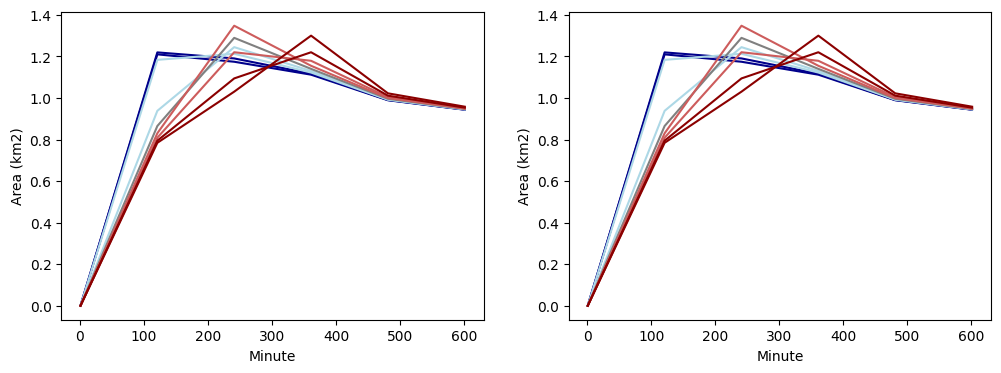

In [23]:
fig, ax = plt.subplots(ncols=2, figsize= (12,4))

colors = ['darkblue', 'darkblue', 'lightblue', 'lightblue', 'grey','indianred','indianred','darkred','darkred' ]

for number, column in enumerate(df_allvalues.columns[:-1]):
      ax[0].plot(df_allvalues["minute"], df_allvalues[column], color = colors[number]);           
               
for number, column in enumerate(df_allvalues.columns[:-1]):
      ax[1].plot(df_allvalues["minute"], df_allvalues[column], color = colors[number])
        

#ax[1].set_xlim(0,700)
ax[0].set_ylabel('Area (km2)')
ax[1].set_ylabel('Area (km2)')
ax[0].set_xlabel('Minute')
ax[1].set_xlabel('Minute');     

# fig.savefig("ProcessModelResults/Outputs/Figs/FloodedArea_OverTime.PNG")

### Only including cells over 10cm which are not permanent water

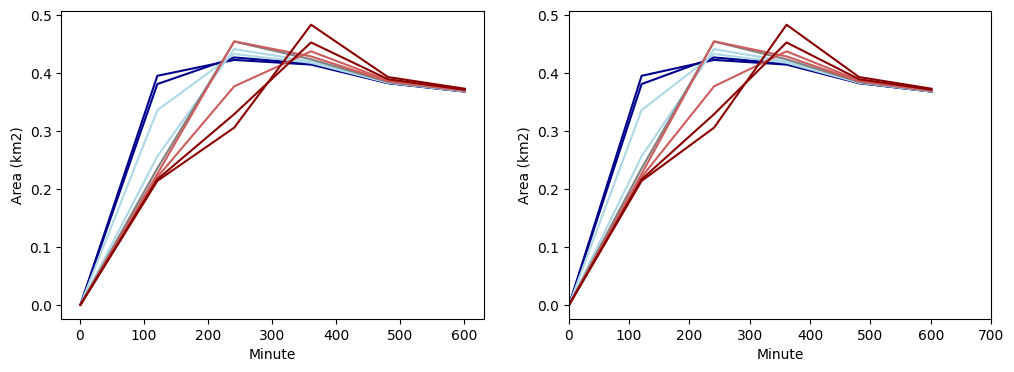

In [26]:
fig, ax = plt.subplots(ncols=2, figsize= (12,4))

for number, column in enumerate(df_notwater.columns[:-1]):
      ax[0].plot(df_notwater["minute"], df_notwater[column], color = colors[number]);           
               
for number, column in enumerate(df_notwater.columns[:-1]):
      ax[1].plot(df_notwater["minute"], df_notwater[column], color = colors[number])

ax[1].set_xlim(0,700)
ax[0].set_ylabel('Area (km2)')
ax[1].set_ylabel('Area (km2)')
ax[0].set_xlabel('Minute')
ax[1].set_xlabel('Minute');     


### Only including cells over 10cm

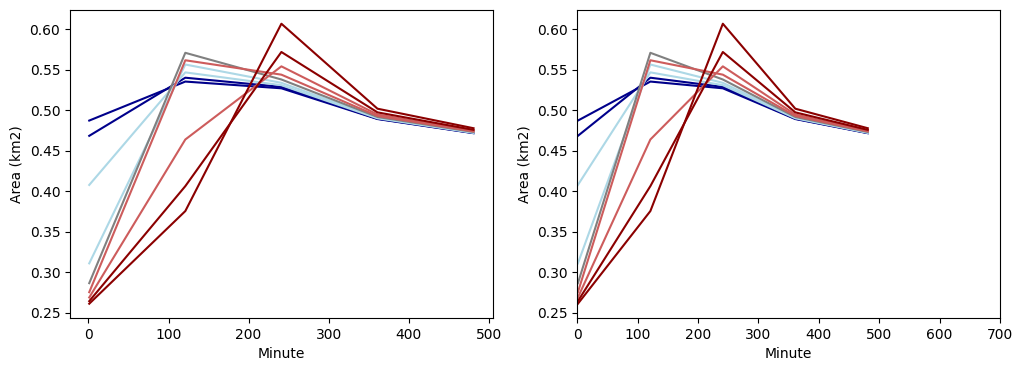

In [68]:
fig, ax = plt.subplots(ncols=2, figsize= (12,4))

for number, column in enumerate(df_2hrs_over10cm.columns[:-1]):
      ax[0].plot(df_2hrs_over10cm["minute"], df_2hrs_over10cm[column], color = colors[number]);           
               
for number, column in enumerate(df_2hrs_over10cm.columns[:-1]):
      ax[1].plot(df_2hrs_over10cm["minute"], df_2hrs_over10cm[column], color = colors[number])

ax[1].set_xlim(0,700)
ax[0].set_ylabel('Area (km2)')
ax[1].set_ylabel('Area (km2)')
ax[0].set_xlabel('Minute')
ax[1].set_xlabel('Minute');     
